## Description

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather

1. Clear, Few clouds, Partly cloudy, Partly cloudy
2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib as mpl

%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus']=False

In [38]:
train=pd.read_csv('./data/train.csv', parse_dates=['datetime'])
test=pd.read_csv('./data/test.csv', parse_dates=['datetime'])

print('train set : ',train.shape)
print('test set : ', test.shape)

train set :  (10886, 12)
test set :  (6493, 9)


In [39]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [40]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [43]:
# 연속형/범주형 feature 분리

catvar=['season','holiday','workingday','weather','dayofweek','year','hour']

In [44]:
for var in catvar:
    train[var]=train[var].astype('category')
    test[var]=test[var].astype('category')

In [47]:
feature_name=['season','weather','temp','atemp','humidity','year','hour','dayofweek','holiday','workingday']

feature_name

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [48]:
x_train=train[feature_name]

print(x_train.shape)
x_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [49]:
x_test=test[feature_name]

print(x_test.shape)
x_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [50]:
label_name='count'

y_train=train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [52]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

### 선형회귀 모델 (Linear Regression Model)

- 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
- 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
- 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.

In [56]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment=None
warnings.filterwarnings('ignore',category=DeprecationWarning)

# 선형회귀모델 초기화

linear=LinearRegression()

# 모델 학습
y_train_log=np.log1p(y_train)
linear.fit(x_train,y_train_log)

# 예측 및 정확도 평가
y_pred=linear.predict(x_train)
print('RMSLE Values For Linear Regression : ',rmsle(np.exp(y_train_log),np.exp(y_pred),False))

RMSLE Values For Linear Regression :  0.9803697923313504


### 릿지 (Regularization Model - Ridge)

- 회귀를 위한 선형모델
- 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피쳐가 주는 영향을 최소화(기울기를 작게)
- Regularization(규제)는 과대적합이 되지 않도록 모델을 강제로 제한한다는 의미

In [61]:
ridge=Ridge()
ridge_params={'max_iter':[3000], 'alpha':[0.01,0.1,0.5,1,2,3,4,10,30,100,200,300,400,800,900,1000]}
rmsle_scorer=make_scorer(rmsle, greater_is_better=False) #rmlse 는 작을수록 좋음

ridge_grid=GridSearchCV(ridge, ridge_params, scoring=rmsle_scorer, cv=5)

y_train_log=np.log1p(y_train)
ridge_grid.fit(x_train, y_train_log)

y_pred=ridge_grid.predict(x_train)
print (ridge_grid.best_params_)

print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(y_pred), False))
df = pd.DataFrame(ridge_grid.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780806


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015767,0.002490,0.005983,0.001094,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.012767,0.000748,0.004785,0.001163,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.012366,0.001494,0.004787,0.000400,0.5,3000,"{'alpha': 0.5, 'max_iter': 3000}",-1.003152,-0.906727,-1.029927,-1.016626,-0.982322,-0.987751,0.043461,3
3,0.012767,0.001324,0.005185,0.000747,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,4
4,0.012767,0.000978,0.004786,0.000978,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,5


In [62]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,0.50,0.987751
3,1.00,0.987755
4,2.00,0.987762


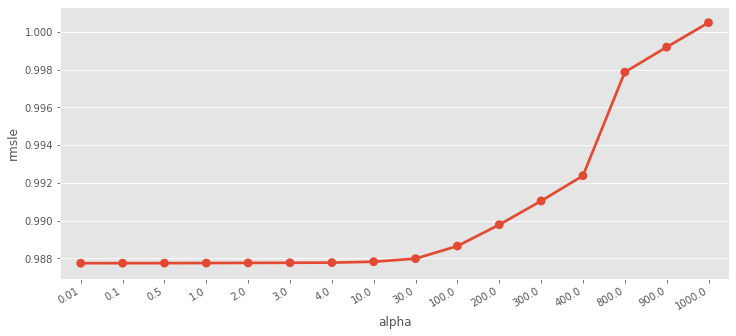

In [63]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 라쏘 (Regularization Model - Lasso)

- 선형회귀의 Regularization(규제)를 적용하는 대안
- 계수를 0에 가깝고 만들려고 하며 이를 L1 규제라고 하고, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피쳐가 생긴다는 의미다
- alpha 값의 기본값은 1.0 이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야한다

In [66]:
lasso=Lasso()
alpha=1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])
lasso_params={'max_iter':[3000],'alpha':alpha}

lasso_grid=GridSearchCV(lasso, lasso_params, scoring=rmsle_scorer, cv=5)

y_train_log=np.log1p(y_train)
lasso_grid.fit(x_train, y_train_log)

y_pred=lasso_grid.predict(x_train)
print(lasso_grid.best_params_)

print('RMSLE Valuse For Lasso Regression : ',rmsle(np.exp(y_train_log), np.exp(y_pred), False))

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Valuse For Lasso Regression :  0.9803727821457643


In [70]:
df = pd.DataFrame(lasso_grid.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].tail()

,alpha,rmsle
9,0.003333,0.987802
10,0.002500,0.987734
11,0.001250,0.987712
12,0.001111,0.987714
13,0.001000,0.987713


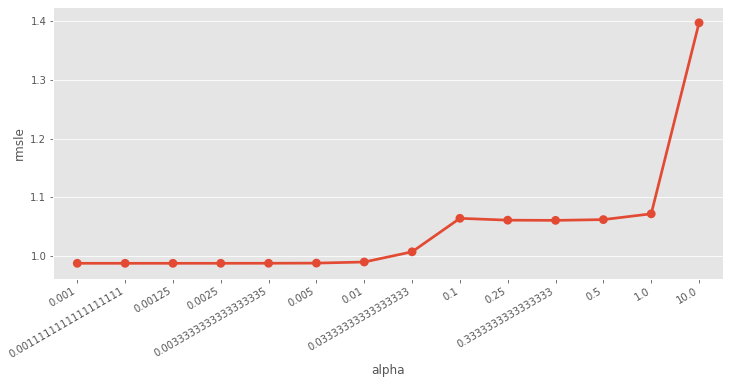

In [72]:
figure, ax=plt.subplots()
figure.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x='alpha', y='rmsle', ax=ax)

### 앙상블모델 - 랜덤포레스트

In [79]:
from sklearn.ensemble import RandomForestRegressor

rfModel=RandomForestRegressor(n_estimators=100)

y_train_log=np.log1p(y_train)

rfModel.fit(x_train, y_train_log)

y_pred=rfModel.predict(x_train)

print('RMSLE Value For RandomForest : ',rmsle(np.exp(y_train_log), np.exp(y_pred),False))

RMSLE Value For RandomForest :  0.10737771316997154


### 앙상블모델 - 그라디언트 부스트

#### Ensemble Model - Gradient Boost

- 여러개의 결정트리르 묵어 강력한 모델을 만드는 또 다른 기법
- 회귀와 분류에 모두 사용할 수 있음
- 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
- 무작위성이 없고 강력한 사전 가지치기가 사용 됨
- 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
- learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
- n_estimators의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 과대적합이 될 수 있다.
- max_depth(max_leaf_nodes) : 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [75]:
from sklearn.ensemble import GradientBoostingRegressor

gbr=GradientBoostingRegressor(n_estimators=4000, alpha=0.01)

y_train_log=np.log1p(y_train)
gbr.fit(x_train, y_train_log)

y_pred=gbr.predict(x_train)

print('RMSLE Value For Gradient Boost : ', rmsle(np.exp(y_train_log), np.exp(y_pred), False))

RMSLE Value For Gradient Boost :  0.21357403727249366


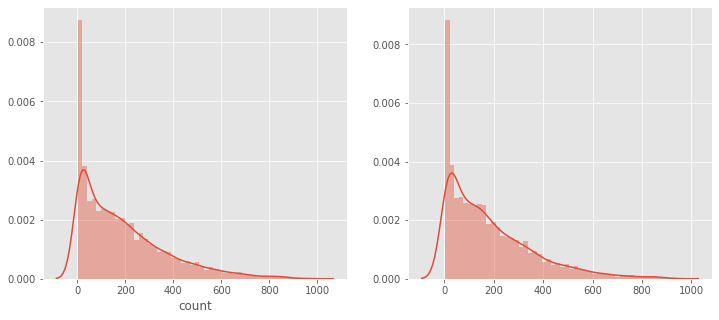

In [76]:
predTest=rfModel.predict(x_test)

fig,axes=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=axes[0], bins=50)
sns.distplot(np.exp(predTest), ax=axes[1],bins=50)

## Submit

In [77]:
submission=pd.read_csv('./data/sampleSubmission.csv')

submission['count']=np.exp(predTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.381540
1,2011-01-20 01:00:00,5.185042
2,2011-01-20 02:00:00,3.566655
3,2011-01-20 03:00:00,4.566082
4,2011-01-20 04:00:00,3.731295


In [81]:
submission.to_csv('Score_{0:.5f}_submission.csv'.format(rmsle(np.exp(y_train_log), np.exp(y_pred), False)),index=False)